In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from glob import glob

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


size = 224
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper
bootstrap_ci(roc_auc_score, test, predict)

def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

2024-02-16 19:01:56.435639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 19:01:57.416778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


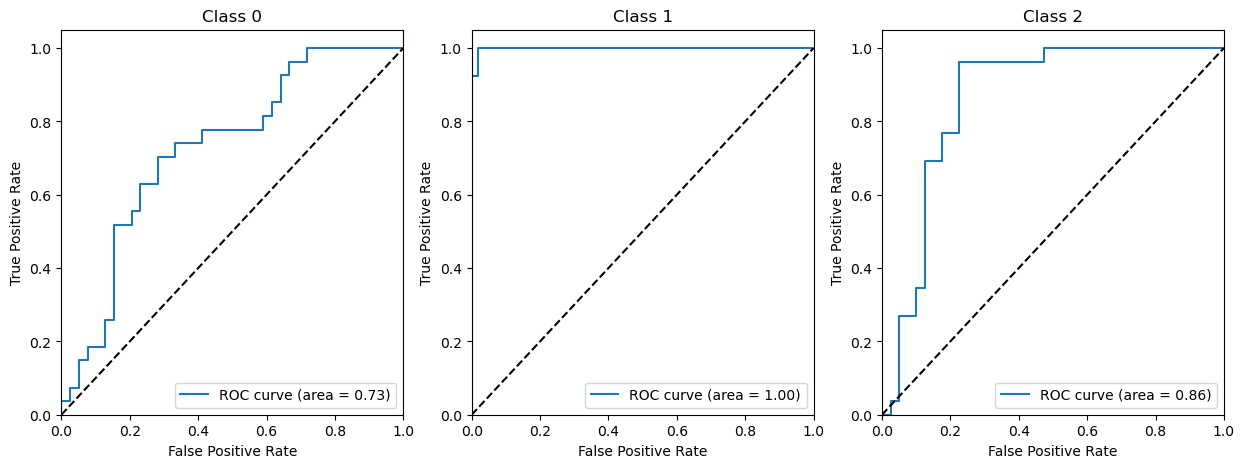

roc_auc_score:  0.8621942697414395


(0.8087388263715977, 0.9120686551380182)

In [4]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper

# make sample data
n_classes = 3
X, y = make_classification(n_samples=200, n_features=5,
                           n_informative=3, n_redundant=2
                           , n_clusters_per_class=2
                           , n_classes=n_classes
                           , weights=[0.3, 0.2, 0.5]
                           , random_state=99)

y = label_binarize(y, classes=[0,1,2])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# classifier
clf = OneVsRestClassifier(GaussianNB())
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
  # 나이브베이즈 모델은 predict_proba 메서드로 각 클래스별 probability를 구할 수 있습니다.

# ROC & AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(n_classes)):
    plt.subplot(131+idx)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")
plt.show()

print("roc_auc_score: ", roc_auc_score(y_test, y_score, multi_class='raise'))
bootstrap_ci(roc_auc_score, y_test,y_score)

In [2]:
test_df = pd.read_csv(
    '../../data/classificationDDH/test_aug_classification_dataset.csv')


test_img_list = test_df['file name'].to_list()
test_label_list = test_df['standard class'].to_list()
test_case_list = test_df['case'].to_list()
test_img_path = '../../data/classificationDDH/aug_dataset/test/'


x_test = np.zeros((len(test_img_list), size, size, 3), dtype=np.uint8)
for i in tqdm(range(len(test_img_list))):
    x_test[i] = np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/'+test_img_list[i]).resize((size, size)))
y_test = np.array(test_label_list)


  0%|          | 0/3476 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
model = K.models.load_model('../../model/classification/MobileNetV2_checkpoints.h5')
MobileNetV2_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/MobileNetV1_acc_checkpoints.h5')
MobileNetV1_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/DenseNet121_checkpoints.h5')
DenseNet121_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/EfficientNetV2B0_checkpoints.h5')
EfficientNetV2B0_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/NASNetMobile_checkpoints.h5')
NASNetMobile_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/ResNet50_checkpoints.h5')
ResNet50_pre=model.predict(x_test)
print(model.count_params())

2024-01-17 18:27:57.703319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38163 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0
2024-01-17 18:28:02.245768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


 16/109 [===>..........................] - ETA: 1s

2024-01-17 18:28:02.757766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


109/109 [==============================] - 3s 8ms/step
3603113
109/109 [==============================] - 1s 6ms/step
4317993
109/109 [==============================] - 3s 16ms/step
8126633
109/109 [==============================] - 2s 9ms/step
7264441
109/109 [==============================] - 4s 15ms/step
5390845
109/109 [==============================] - 2s 14ms/step
25700841


(0.0, 1.0)

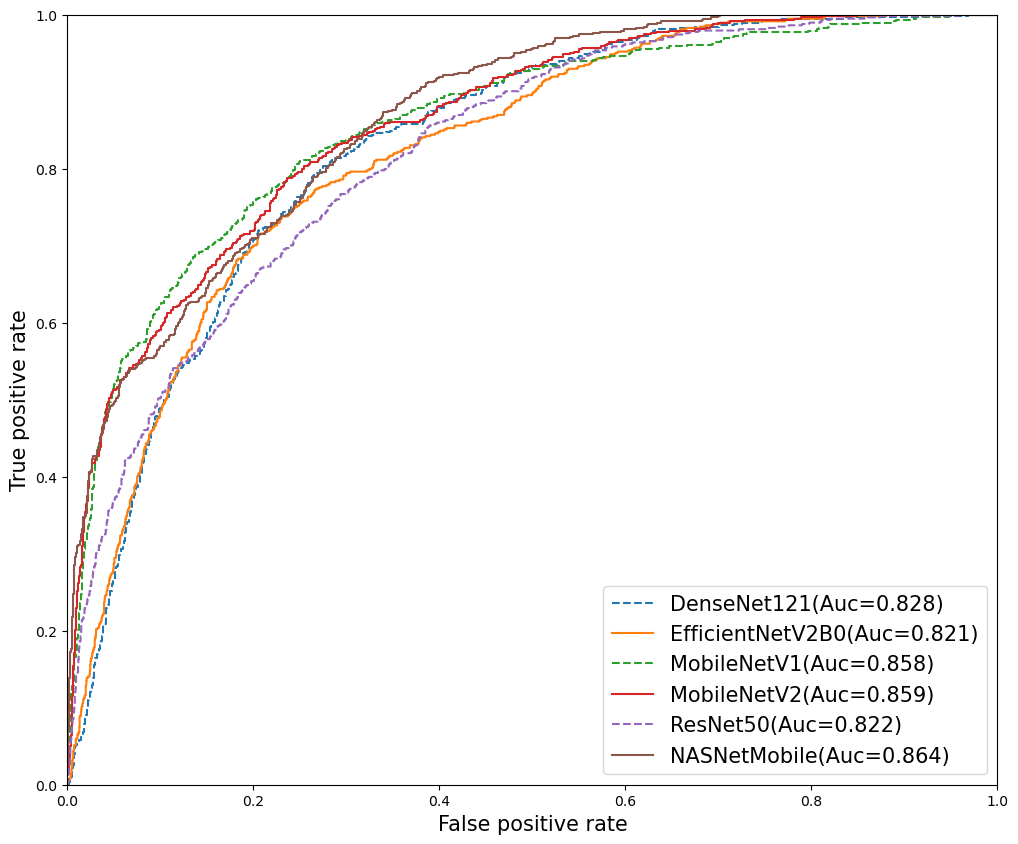

In [4]:
MobileNetV2_fper,MobileNetV2_tper, thresholds = roc_curve(y_test, MobileNetV2_pre)
MobileNetV1_fper,MobileNetV1_tper, thresholds = roc_curve(y_test, MobileNetV1_pre)
DenseNet121_fper,DenseNet121_tper, thresholds = roc_curve(y_test, DenseNet121_pre)
EfficientNetV2B0_fper,EfficientNetV2B0_tper, thresholds = roc_curve(y_test, EfficientNetV2B0_pre)
NASNetMobile_fper,NASNetMobile_tper, thresholds = roc_curve(y_test, NASNetMobile_pre)
ResNet50_fper,ResNet50_tper, thresholds = roc_curve(y_test, ResNet50_pre)
MobileNetV2_auc_score=roc_auc_score(y_test, MobileNetV2_pre)
MobileNetV1_auc_score=roc_auc_score(y_test, MobileNetV1_pre)
DenseNet121_auc_score=roc_auc_score(y_test, DenseNet121_pre)
EfficientNetV2B0_auc_score=roc_auc_score(y_test, EfficientNetV2B0_pre)
NASNetMobile_auc_score=roc_auc_score(y_test, NASNetMobile_pre)
ResNet50_auc_score=roc_auc_score(y_test, ResNet50_pre)
plt.figure(figsize=(12,10))
plt.plot(DenseNet121_fper, DenseNet121_tper,label='DenseNet121(Auc='+str(round(DenseNet121_auc_score, 3))+')',linestyle='--')
plt.plot(EfficientNetV2B0_fper, EfficientNetV2B0_tper,label='EfficientNetV2B0(Auc='+str(round(EfficientNetV2B0_auc_score, 3))+')')
plt.plot(MobileNetV1_fper, MobileNetV1_tper,label='MobileNetV1(Auc='+str(round(MobileNetV1_auc_score, 3))+')',linestyle='--')
plt.plot(MobileNetV2_fper,MobileNetV2_tper,label='MobileNetV2(Auc='+str(round(MobileNetV2_auc_score, 3))+')')
plt.plot(ResNet50_fper,ResNet50_tper,label='ResNet50(Auc='+str(round(ResNet50_auc_score, 3))+')',linestyle='--')
plt.plot(NASNetMobile_fper,NASNetMobile_tper,label='NASNetMobile(Auc='+str(round(NASNetMobile_auc_score, 3))+')')
plt.legend(fontsize=15)
plt.xlabel('False positive rate',size=15)
plt.ylabel('True positive rate',size=15)
plt.xlim([0, 1])      # X축의 범위: [xmin, xmax]
plt.ylim([0, 1]) 


In [25]:
GT=np.array([[0,0,1],[0, 1, 0],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 1, 0],[1, 0, 0],[1, 0, 0],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 1, 0],[1, 0, 0],[1, 0, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[1, 0, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[1, 0, 0],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 0, 1],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 1],[0, 1, 0],[0, 0, 1],[0, 1, 0],[1, 0, 0]])
SVM=np.array([[1.26642346e-03, 1.54061631e-01, 8.44671945e-01,],[2.29136839e-01, 7.37123506e-01, 3.37396547e-02,],[7.54637616e-01, 2.43632783e-01, 1.72960101e-03,],[2.12932167e-02, 8.31179820e-01, 1.47526963e-01,],[5.19260977e-03, 2.44110806e-02, 9.70396310e-01,],[8.58143601e-05, 3.71138262e-02, 9.62800359e-01,],[2.08743347e-04, 2.05795869e-01, 7.93995388e-01,],[2.38145416e-04, 2.08681094e-02, 9.78893745e-01,],[2.67536843e-04, 2.63416392e-02, 9.73390824e-01,],[2.89202135e-04, 4.01433485e-02, 9.59567449e-01,],[6.27898832e-01, 3.59192361e-01, 1.29088067e-02,],[4.27287081e-01, 5.53740448e-01, 1.89724706e-02,],[3.26334280e-04, 8.56239696e-02, 9.14049696e-01,],[1.60467564e-01, 7.92142615e-01, 4.73898205e-02,],[5.05727846e-03, 6.04985023e-02, 9.34444219e-01,],[1.04769278e-03, 1.28091183e-01, 8.70861124e-01,],[1.03481308e-01, 1.44404507e-01, 7.52114185e-01,],[5.68986751e-01, 9.02480417e-02, 3.40765207e-01,],[4.01923516e-05, 1.38721952e-03, 9.98572588e-01,],[4.96871747e-03, 6.08236461e-01, 3.86794822e-01,],[1.96419405e-03, 1.65475173e-01, 8.32560633e-01,],[1.38860374e-03, 9.67034551e-02, 9.01907941e-01,],[8.54854508e-01, 4.05385048e-02, 1.04606987e-01,],[9.94673394e-01, 5.11666105e-03, 2.09945403e-04,],[2.37554333e-04, 2.24525990e-01, 7.75236456e-01,],[8.76086965e-02, 7.98356319e-01, 1.14034984e-01,],[8.98701266e-01, 7.00180373e-02, 3.12806968e-02,],[9.59597901e-03, 7.82273574e-01, 2.08130447e-01,],[5.42951897e-01, 2.54119949e-01, 2.02928154e-01,],[8.81567850e-01, 1.08449105e-01, 9.98304505e-03,],[6.56214172e-01, 3.15081601e-01, 2.87042267e-02,],[2.28367263e-01, 6.53737157e-01, 1.17895580e-01,],[9.64574656e-04, 2.41043693e-01, 7.57991733e-01,],[1.23194559e-03, 7.22811119e-02, 9.26486943e-01,],[2.05819161e-02, 6.29701899e-01, 3.49716185e-01,],[1.18822143e-03, 9.64013567e-02, 9.02410422e-01,],[1.91704403e-01, 7.81472002e-01, 2.68235951e-02,],[7.27038274e-03, 1.30790439e-01, 8.61939178e-01,],[1.60201818e-01, 7.54078341e-01, 8.57198413e-02,],[2.45171260e-03, 4.52342663e-02, 9.52314021e-01,],[9.68814382e-01, 2.90922310e-02, 2.09338654e-03,],[1.04454231e-02, 3.22333833e-01, 6.67220744e-01,],[2.02102765e-02, 7.57651644e-01, 2.22138080e-01,],[6.61059003e-04, 7.36377137e-03, 9.91975170e-01,],[3.39527330e-02, 7.41166532e-01, 2.24880735e-01,],[3.37158936e-01, 6.44012942e-01, 1.88281219e-02,],[1.83577331e-03, 2.45983725e-01, 7.52180501e-01,],[8.40572932e-04, 5.78993303e-01, 4.20166124e-01,],[4.47387681e-03, 1.10871086e-01, 8.84655038e-01,],[1.88511431e-01, 7.70769642e-01, 4.07189263e-02,],[8.28322731e-01, 1.58281431e-01, 1.33958376e-02,],[1.69270375e-03, 5.29650891e-01, 4.68656406e-01,],[6.44004297e-03, 9.10234962e-01, 8.33249952e-02,],[1.83220032e-01, 7.07195723e-01, 1.09584245e-01,],[2.05086765e-04, 1.43449876e-01, 8.56345037e-01,],[5.66094708e-04, 3.26417147e-01, 6.73016758e-01,],[8.25450010e-01, 1.65324124e-01, 9.22586629e-03,],[3.10482858e-01, 6.87334382e-01, 2.18275975e-03,],[1.60555654e-03, 1.89913860e-02, 9.79403057e-01,],[1.99552649e-02, 8.69116080e-01, 1.10928655e-01,],[8.10241812e-03, 7.89871299e-01, 2.02026283e-01,],[7.48698510e-05, 2.10769019e-02, 9.78848228e-01,],[1.65417150e-03, 4.69891723e-05, 9.98298839e-01,],[2.43011165e-04, 1.54901395e-03, 9.98207975e-01,],[5.60648960e-02, 8.36827459e-01, 1.07107645e-01,],[3.35140369e-04, 6.19120769e-05, 9.99602948e-01,],[1.90106724e-01, 4.19768588e-01, 3.90124688e-01,],[1.28908687e-02, 8.07116047e-01, 1.79993084e-01,],[2.02741861e-03, 5.31507943e-01, 4.66464638e-01,],[3.12225645e-04, 1.23966748e-02, 9.87291100e-01,],[3.05797191e-02, 7.49151267e-01, 2.20269014e-01,],[5.96160229e-03, 7.04194438e-01, 2.89843960e-01,],[7.79680154e-02, 4.87970415e-01, 4.34061570e-01,],[7.31161958e-01, 2.38321668e-01, 3.05163744e-02,],[6.51071289e-03, 5.59706247e-04, 9.92929581e-01,],[4.80235765e-03, 1.81069657e-01, 8.14127985e-01,],[4.53975668e-04, 8.06267422e-02, 9.18919282e-01,],[1.12018478e-02, 6.44948316e-01, 3.43849836e-01,],[9.09418377e-02, 8.83980728e-01, 2.50774343e-02,],[8.43650008e-01, 1.14848027e-01, 4.15019655e-02,],[2.91357330e-05, 3.68993479e-03, 9.96280929e-01,],[2.60146213e-04, 1.65384989e-01, 8.34354865e-01,],[2.13632723e-03, 4.90660366e-01, 5.07203306e-01,],[3.13983272e-02, 7.74924241e-01, 1.93677432e-01,],[5.96829976e-01, 4.01709515e-01, 1.46050900e-03,],[9.05834629e-01, 9.38831091e-02, 2.82261722e-04,],[2.75151200e-04, 3.09683919e-01, 6.90040930e-01,],[2.09563546e-02, 8.69487799e-01, 1.09555847e-01,],[4.02797682e-03, 5.68142153e-01, 4.27829870e-01,],[8.95578602e-01, 6.95650505e-02, 3.48563480e-02,],[1.28813948e-03, 7.93153629e-01, 2.05558231e-01,],[6.35429596e-05, 9.93071227e-02, 9.00629334e-01,],[5.08143025e-02, 6.00588255e-01, 3.48597442e-01,],[1.48536111e-03, 6.79011965e-02, 9.30613442e-01,],[9.71223494e-01, 2.35035291e-02, 5.27297702e-03,],[2.99134760e-02, 8.22500891e-01, 1.47585633e-01,],[6.40261715e-02, 8.60670072e-01, 7.53037570e-02,],[9.99029337e-01, 9.54105441e-04, 1.65571104e-05,],[8.62969191e-01, 1.36724889e-01, 3.05920053e-04,],[7.07035619e-02, 8.77488705e-01, 5.18077326e-02,],[1.90580940e-02, 8.04808289e-01, 1.76133617e-01,],[1.46980686e-02, 2.26161738e-06, 9.85299670e-01,],[2.33620945e-04, 3.11957104e-01, 6.87809275e-01,],[7.13794858e-01, 2.83743962e-01, 2.46118094e-03,],[5.36540847e-01, 4.07551530e-01, 5.59076229e-02,],[8.82771615e-01, 1.12640117e-01, 4.58826802e-03,],[4.41805599e-03, 9.89276016e-02, 8.96654342e-01,],[2.35453305e-03, 5.69815526e-01, 4.27829941e-01,],[4.74484674e-01, 5.15606778e-01, 9.90854887e-03,],[1.60245784e-03, 4.95466718e-01, 5.02930824e-01,],[9.57819884e-01, 3.97784762e-02, 2.40163988e-03,],[9.53585449e-01, 4.33681936e-02, 3.04635763e-03,],[6.53470282e-04, 2.29380886e-02, 9.76408441e-01,],[7.55934344e-02, 4.46698220e-02, 8.79736744e-01,],[2.14356667e-01, 7.71706562e-01, 1.39367715e-02,],[1.26856680e-01, 8.48011774e-01, 2.51315458e-02,],[9.66149982e-05, 2.46171829e-01, 7.53731556e-01,],[9.89608040e-01, 1.01632833e-02, 2.28676671e-04,],[3.72267500e-01, 5.87413816e-01, 4.03186836e-02,],[5.52522732e-02, 5.35856677e-01, 4.08891050e-01,],[5.29985271e-03, 6.46627168e-01, 3.48072979e-01,],[7.88582979e-02, 3.10110144e-01, 6.11031558e-01,],[8.53203620e-01, 9.74776854e-02, 4.93186949e-02,],[7.12837690e-03, 2.52170898e-01, 7.40700725e-01,],[4.17707898e-03, 2.72245458e-01, 7.23577463e-01,],[8.39286990e-04, 2.56361515e-01, 7.42799198e-01,],[2.03164796e-03, 2.51962306e-01, 7.46006046e-01,],[5.10352345e-03, 3.94366906e-01, 6.00529571e-01,],[1.41340232e-02, 7.97570781e-01, 1.88295196e-01,],[4.61423814e-01, 5.26531687e-01, 1.20444984e-02,],[6.99561051e-01, 2.98322238e-01, 2.11671170e-03,],[1.77695885e-01, 7.39642391e-01, 8.26617241e-02,],[5.76484675e-03, 3.71618848e-01, 6.22616305e-01,],[2.39551915e-03, 3.23231697e-02, 9.65281311e-01,],[8.91172865e-03, 1.49500555e-01, 8.41587716e-01,],[3.15259398e-02, 8.29456268e-01, 1.39017792e-01,],[1.02699613e-03, 2.03149891e-01, 7.95823112e-01,],[6.46465299e-06, 9.78348073e-02, 9.02158728e-01,],[1.24318611e-01, 5.42396566e-01, 3.33284823e-01,],[6.01197196e-04, 2.47501291e-01, 7.51897511e-01,],[9.34110336e-01, 5.11051717e-02, 1.47844923e-02,],[6.06816024e-04, 6.56403442e-01, 3.42989742e-01,],[4.47376016e-01, 5.41142186e-01, 1.14817984e-02,],[3.94947289e-03, 5.28529932e-01, 4.67520595e-01,],[7.26683619e-03, 3.63020486e-01, 6.29712678e-01,],[5.68730705e-03, 7.44391846e-01, 2.49920847e-01,],[2.43902864e-01, 3.78002280e-01, 3.78094856e-01,],[5.34596820e-04, 4.96421209e-02, 9.49823282e-01,],[2.56978407e-01, 7.26787062e-01, 1.62345311e-02,],[8.65555030e-02, 8.23313577e-01, 9.01309201e-02,],[3.25231005e-03, 6.92872998e-01, 3.03874692e-01,],[1.06364710e-02, 6.52992909e-01, 3.36370620e-01,],[4.97530612e-03, 5.87313427e-04, 9.94437380e-01,],[1.55101542e-02, 8.52720835e-01, 1.31769011e-01,],[7.60024034e-01, 2.38989459e-01, 9.86507461e-04,],[7.66690694e-03, 4.62738840e-01, 5.29594253e-01,],[1.68750035e-03, 2.82350957e-01, 7.15961543e-01,],[1.20165840e-03, 3.67451098e-01, 6.31347243e-01,],[7.73477039e-01, 2.25036385e-01, 1.48657655e-03,],[3.36275173e-03, 6.13801059e-01, 3.82836189e-01,],[2.16229298e-03, 1.10684790e-01, 8.87152917e-01,],[7.82636502e-03, 1.22355516e-01, 8.69818119e-01,],[1.92458377e-03, 2.46554545e-01, 7.51520871e-01,],[1.19114822e-02, 8.50302161e-01, 1.37786357e-01,],[1.59872735e-04, 1.61954155e-01, 8.37885972e-01,],[5.95688972e-01, 3.99750890e-01, 4.56013789e-03,],[3.51030180e-03, 8.43791184e-01, 1.52698515e-01,],[7.47903409e-01, 2.50543821e-01, 1.55277004e-03,],[7.07123842e-03, 7.68243450e-01, 2.24685312e-01,],[1.52607819e-01, 8.28594870e-01, 1.87973119e-02,],[9.47425127e-03, 3.94326426e-01, 5.96199323e-01,],[8.70384340e-01, 8.73484765e-02, 4.22671837e-02,],[9.19510097e-01, 8.02965258e-02, 1.93376791e-04,],[7.65046295e-01, 2.28773347e-01, 6.18035876e-03,],[4.63451081e-04, 2.25753194e-01, 7.73783355e-01,],[1.16537497e-04, 3.33864330e-01, 6.66019133e-01,],[1.30452520e-02, 8.83584116e-02, 8.98596336e-01,],[7.48371906e-01, 2.25145202e-01, 2.64828919e-02,],[1.81829450e-01, 7.90018022e-01, 2.81525273e-02,],[9.92000476e-03, 1.37867433e-01, 8.52212563e-01,],[5.92553350e-01, 3.58712538e-01, 4.87341120e-02,],[9.72000684e-04, 4.61311040e-02, 9.52896895e-01,],[9.10993855e-02, 2.31865105e-02, 8.85714104e-01,],[7.97842358e-02, 3.65770285e-01, 5.54445479e-01,],[9.85644551e-01, 1.42613877e-02, 9.40613700e-05,],[9.42327688e-01, 5.74146949e-02, 2.57616675e-04,],[1.56751197e-05, 9.25787719e-03, 9.90726448e-01,],[1.06315308e-01, 8.22022181e-01, 7.16625111e-02,],[1.56375991e-03, 7.43731292e-01, 2.54704948e-01,],[6.05632196e-01, 3.90438897e-01, 3.92890704e-03,],[5.09071548e-05, 2.83379091e-02, 9.71611184e-01,],[4.75641242e-05, 3.01928105e-02, 9.69759625e-01,],[1.46933090e-02, 6.70773129e-01, 3.14533562e-01,],[7.35422738e-03, 7.23526444e-01, 2.69119328e-01,],[2.93878558e-04, 8.89674555e-03, 9.90809376e-01,],[1.01270263e-03, 1.52490609e-01, 8.46496689e-01,],[2.84750657e-03, 3.95890423e-01, 6.01262070e-01,],[9.82188952e-02, 8.59926792e-01, 4.18543128e-02,],[2.80765176e-01, 2.61889834e-01, 4.57344990e-01,],[5.09002911e-03, 7.70130118e-01, 2.24779853e-01,],[8.76624639e-03, 4.07218095e-02, 9.50511944e-01,],[1.42841480e-02, 4.21384056e-05, 9.85673714e-01,],[2.14959007e-02, 7.77482646e-01, 2.01021453e-01,],[1.52265462e-04, 2.00512597e-01, 7.99335137e-01,],[5.73083618e-02, 2.46299928e-01, 6.96391710e-01,],[1.43377922e-03, 4.19697145e-01, 5.78869076e-01,],[4.78207214e-01, 5.01515932e-01, 2.02768549e-02,],[9.59930252e-01, 3.92240352e-02, 8.45712414e-04,],[7.34801462e-04, 2.98701739e-01, 7.00563459e-01,],[6.37960084e-02, 8.37271050e-01, 9.89329420e-02,],[7.61930900e-01, 2.33691567e-01, 4.37753239e-03,],[2.05891088e-02, 6.06490474e-01, 3.72920418e-01,],[5.23762954e-04, 6.20019625e-01, 3.79456613e-01,],[1.80961688e-04, 2.80064358e-01, 7.19754680e-01,],[2.52726729e-03, 1.39028672e-01, 8.58444061e-01,],[1.19600176e-02, 5.69145506e-01, 4.18894476e-01,],[7.57150580e-03, 2.25561923e-01, 7.66866571e-01,],[6.43760007e-01, 3.02067621e-01, 5.41723718e-02,],[3.20672110e-02, 9.57434449e-01, 1.04983395e-02,],[5.49731238e-03, 1.38578824e-01, 8.55923863e-01,],[6.49454433e-04, 5.92524107e-01, 4.06826438e-01,],[5.72141683e-02, 9.64878799e-03, 9.33137044e-01,],[5.20501474e-04, 1.11548605e-01, 8.87930893e-01,],[2.83756088e-01, 6.82395234e-01, 3.38486781e-02,],[8.29797621e-01, 1.52451572e-01, 1.77508066e-02,],[8.47614022e-03, 1.11393218e-01, 8.80130642e-01,],[1.03227538e-01, 8.96238039e-01, 5.34423087e-04,],[2.90423158e-03, 6.00456414e-01, 3.96639354e-01,],[2.71436063e-01, 1.29891539e-01, 5.98672398e-01,],[1.62908621e-04, 2.58851652e-03, 9.97248575e-01,],[2.92067901e-02, 8.10561713e-01, 1.60231497e-01,],[8.79995358e-05, 1.04675646e-02, 9.89444436e-01,],[6.05264321e-04, 1.42978386e-01, 8.56416349e-01,],[3.05517195e-01, 6.70474193e-01, 2.40086127e-02,],[7.75748914e-01, 2.07480446e-01, 1.67706399e-02,],[4.47215114e-03, 7.13592419e-01, 2.81935430e-01,],[4.63113598e-04, 7.81916190e-03, 9.91717725e-01,],[6.62315352e-05, 5.86497887e-02, 9.41283980e-01,],[7.92626934e-03, 8.46385609e-01, 1.45688122e-01,],[3.78023421e-04, 4.66663344e-01, 5.32958633e-01,],[4.78470971e-02, 8.26958225e-01, 1.25194678e-01,],[7.71839899e-01, 1.60614416e-01, 6.75456845e-02,]])
LR=np.array([[2.54126238e-04, 1.77461933e-01, 8.22283941e-01,],[2.86400939e-01, 7.01781769e-01, 1.18172917e-02,],[6.32001689e-01, 3.66454448e-01, 1.54386328e-03,],[2.14965533e-02, 8.34533094e-01, 1.43970352e-01,],[2.62480996e-04, 2.79178387e-02, 9.71819680e-01,],[3.76488652e-07, 1.25581904e-01, 8.74417720e-01,],[5.01898475e-06, 3.33229417e-01, 6.66765564e-01,],[4.79082551e-07, 1.09101387e-01, 8.90898134e-01,],[1.26569170e-07, 1.71114205e-01, 8.28885669e-01,],[1.04819986e-06, 1.89964446e-01, 8.10034506e-01,],[4.89614121e-01, 2.59184163e-01, 2.51201716e-01,],[4.09700702e-01, 4.05114866e-01, 1.85184432e-01,],[1.42890254e-06, 2.46715417e-01, 7.53283154e-01,],[2.85242576e-01, 6.41061268e-01, 7.36961561e-02,],[2.80096779e-06, 1.50812858e-01, 8.49184341e-01,],[1.06803784e-05, 2.30289489e-01, 7.69699831e-01,],[4.29462984e-02, 3.82803297e-01, 5.74250405e-01,],[6.37491746e-01, 1.66072048e-01, 1.96436207e-01,],[3.82165564e-09, 1.14949272e-01, 8.85050725e-01,],[1.77902087e-03, 4.26540279e-01, 5.71680700e-01,],[2.14418447e-05, 2.69944723e-01, 7.30033835e-01,],[1.72333824e-07, 2.39061544e-01, 7.60938284e-01,],[8.54064765e-01, 1.21539587e-01, 2.43956486e-02,],[7.62306138e-01, 2.37575827e-01, 1.18035548e-04,],[1.43062302e-05, 2.38111517e-01, 7.61874177e-01,],[4.59804488e-02, 7.62819382e-01, 1.91200170e-01,],[9.56471252e-01, 1.09221034e-02, 3.26066449e-02,],[1.82699339e-02, 6.45869057e-01, 3.35861009e-01,],[7.86729003e-01, 9.28808116e-02, 1.20390186e-01,],[7.03982857e-01, 2.81643995e-01, 1.43731484e-02,],[6.43901926e-01, 3.46849099e-01, 9.24897545e-03,],[1.80676479e-01, 7.63624938e-01, 5.56985834e-02,],[1.15906815e-05, 2.69451340e-01, 7.30537069e-01,],[1.15083792e-07, 2.29978213e-01, 7.70021672e-01,],[9.00834629e-03, 5.70393850e-01, 4.20597804e-01,],[1.19144890e-07, 2.42457168e-01, 7.57542713e-01,],[5.40619990e-01, 4.32343531e-01, 2.70364783e-02,],[2.20569797e-03, 1.93834527e-01, 8.03959775e-01,],[1.25024026e-01, 8.12465717e-01, 6.25102571e-02,],[1.16693337e-04, 1.13086178e-01, 8.86797129e-01,],[8.14959277e-01, 1.84166785e-01, 8.73937543e-04,],[3.85168939e-04, 3.53614326e-01, 6.46000505e-01,],[1.13600891e-02, 7.27693118e-01, 2.60946793e-01,],[1.39301426e-07, 1.20589173e-01, 8.79410688e-01,],[1.73484780e-02, 7.11980794e-01, 2.70670728e-01,],[5.10750889e-01, 4.66413500e-01, 2.28356103e-02,],[1.48933187e-04, 2.63027934e-01, 7.36823133e-01,],[1.98822847e-04, 5.68262250e-01, 4.31538928e-01,],[1.63300594e-06, 1.65756022e-01, 8.34242345e-01,],[1.00529039e-02, 5.21479875e-01, 4.68467221e-01,],[7.05714468e-01, 2.85720639e-01, 8.56489330e-03,],[5.30593340e-04, 4.66353288e-01, 5.33116119e-01,],[7.10127443e-03, 8.88839148e-01, 1.04059577e-01,],[2.35237324e-01, 6.78764622e-01, 8.59980534e-02,],[6.56668011e-06, 2.28256764e-01, 7.71736669e-01,],[4.22519484e-05, 4.11920205e-01, 5.88037543e-01,],[6.18837323e-01, 3.71746433e-01, 9.41624387e-03,],[3.73369290e-01, 6.17107242e-01, 9.52346751e-03,],[3.89311464e-08, 1.30041337e-01, 8.69958624e-01,],[2.08597245e-02, 8.45907355e-01, 1.33232921e-01,],[4.65440659e-03, 8.05940019e-01, 1.89405574e-01,],[7.59103019e-08, 2.00213173e-01, 7.99786751e-01,],[1.86234633e-11, 3.33236477e-02, 9.66676352e-01,],[2.67350497e-09, 1.17658533e-01, 8.82341465e-01,],[1.31303442e-01, 5.76786905e-01, 2.91909653e-01,],[1.56260131e-10, 6.11065369e-02, 9.38893463e-01,],[2.84541653e-03, 1.93065105e-01, 8.04089478e-01,],[7.45697653e-03, 6.86889742e-01, 3.05653281e-01,],[1.44938776e-03, 3.25389586e-01, 6.73161027e-01,],[2.02781410e-07, 1.36472317e-01, 8.63527480e-01,],[2.74496839e-02, 7.49552286e-01, 2.22998030e-01,],[1.94122552e-03, 7.02228329e-01, 2.95830445e-01,],[3.99725555e-02, 2.12510467e-01, 7.47516977e-01,],[7.17939705e-01, 2.63928831e-01, 1.81314637e-02,],[9.10744800e-10, 3.81063900e-02, 9.61893609e-01,],[1.99918910e-05, 2.43376579e-01, 7.56603429e-01,],[1.60139318e-05, 1.80493559e-01, 8.19490427e-01,],[3.41744467e-03, 5.38439597e-01, 4.58142958e-01,],[9.46915059e-03, 7.31863411e-01, 2.58667438e-01,],[9.36543985e-01, 4.51566139e-02, 1.82994014e-02,],[2.79643618e-09, 1.11336112e-01, 8.88663886e-01,],[1.01409787e-05, 2.45856430e-01, 7.54133429e-01,],[2.80510331e-05, 3.53607926e-01, 6.46364023e-01,],[1.54061000e-02, 6.79681990e-01, 3.04911910e-01,],[5.41357325e-01, 4.56677021e-01, 1.96565309e-03,],[5.66523189e-01, 4.33163359e-01, 3.13451573e-04,],[4.60634746e-05, 2.41009420e-01, 7.58944516e-01,],[2.17701047e-02, 8.48050517e-01, 1.30179379e-01,],[1.98542722e-03, 4.97894240e-01, 5.00120332e-01,],[3.24666036e-01, 3.80690053e-01, 2.94643912e-01,],[7.14869032e-04, 7.34381915e-01, 2.64903216e-01,],[4.47002631e-07, 2.89143087e-01, 7.10856466e-01,],[2.86691722e-03, 6.45857043e-01, 3.51276039e-01,],[4.29821092e-07, 1.89866941e-01, 8.10132629e-01,],[8.36922644e-01, 1.61543011e-01, 1.53434528e-03,],[2.82075961e-02, 8.37050551e-01, 1.34741853e-01,],[7.46780597e-02, 8.46534375e-01, 7.87875650e-02,],[5.62014787e-01, 4.37969119e-01, 1.60938524e-05,],[6.14134530e-01, 3.84921348e-01, 9.44121902e-04,],[7.78009153e-02, 8.75661701e-01, 4.65373832e-02,],[7.53612775e-03, 8.46107696e-01, 1.46356177e-01,],[1.83051733e-13, 1.17192446e-02, 9.88280755e-01,],[3.23940194e-05, 2.23317928e-01, 7.76649678e-01,],[5.44646596e-01, 4.53561413e-01, 1.79199130e-03,],[4.32938877e-01, 5.30243908e-01, 3.68172153e-02,],[8.16356931e-01, 1.82164686e-01, 1.47838336e-03,],[3.18057432e-06, 1.61384949e-01, 8.38611871e-01,],[1.83195086e-03, 3.93468839e-01, 6.04699210e-01,],[4.17914904e-01, 5.77920070e-01, 4.16502609e-03,],[5.07750822e-04, 4.27248773e-01, 5.72243476e-01,],[8.13352184e-01, 1.85544848e-01, 1.10296849e-03,],[8.29764019e-01, 1.68804967e-01, 1.43101419e-03,],[1.83220061e-09, 1.88945919e-01, 8.11054079e-01,],[2.93892502e-01, 9.16201085e-02, 6.14487389e-01,],[1.80029561e-01, 7.78538877e-01, 4.14315617e-02,],[2.12636972e-01, 7.71685861e-01, 1.56771670e-02,],[4.15566947e-06, 2.91433333e-01, 7.08562511e-01,],[7.66537851e-01, 2.33215390e-01, 2.46758601e-04,],[4.84926491e-01, 4.60244717e-01, 5.48287920e-02,],[1.02879715e-02, 6.92702795e-01, 2.97009233e-01,],[3.16352960e-03, 5.75091606e-01, 4.21744864e-01,],[2.72922026e-02, 4.70059851e-01, 5.02647947e-01,],[9.26698957e-01, 5.66932430e-02, 1.66078000e-02,],[1.85187369e-05, 2.11942876e-01, 7.88038606e-01,],[3.43636547e-04, 2.56319840e-01, 7.43336523e-01,],[2.16516526e-05, 2.91348452e-01, 7.08629897e-01,],[5.19790171e-05, 2.82486308e-01, 7.17461713e-01,],[2.04122433e-05, 3.22323218e-01, 6.77656369e-01,],[4.46196372e-03, 7.97491384e-01, 1.98046652e-01,],[4.38825331e-01, 5.45171389e-01, 1.60032802e-02,],[6.16564624e-01, 3.75263017e-01, 8.17235832e-03,],[1.73671256e-01, 7.01253498e-01, 1.25075245e-01,],[1.24003398e-04, 4.02906855e-01, 5.96969142e-01,],[1.16683719e-07, 1.65078445e-01, 8.34921438e-01,],[3.11455377e-03, 2.23349039e-01, 7.73536407e-01,],[2.16334646e-03, 7.28387844e-01, 2.69448809e-01,],[2.58938789e-05, 2.16363847e-01, 7.83610260e-01,],[3.43937336e-08, 2.46761201e-01, 7.53238765e-01,],[9.36359498e-02, 8.17965034e-01, 8.83990158e-02,],[1.77725263e-04, 1.85881161e-01, 8.13941113e-01,],[9.08582307e-01, 8.55953494e-02, 5.82234390e-03,],[1.32866253e-04, 7.31430122e-01, 2.68437012e-01,],[3.20555495e-01, 6.59265541e-01, 2.01789645e-02,],[5.88308452e-04, 5.86146288e-01, 4.13265404e-01,],[2.34346513e-05, 3.04031859e-01, 6.95944707e-01,],[2.29383175e-04, 7.89271595e-01, 2.10499022e-01,],[5.79780507e-01, 1.14670984e-01, 3.05548509e-01,],[3.68297875e-08, 2.11054382e-01, 7.88945581e-01,],[2.85749810e-01, 6.94751940e-01, 1.94982500e-02,],[1.22036721e-01, 7.48560838e-01, 1.29402441e-01,],[1.64178356e-03, 7.23362219e-01, 2.74995998e-01,],[5.21847775e-04, 4.67993875e-01, 5.31484277e-01,],[3.22905867e-10, 4.88793018e-02, 9.51120698e-01,],[1.53040414e-02, 8.21301927e-01, 1.63394031e-01,],[5.51328091e-01, 4.47720101e-01, 9.51807722e-04,],[1.13104857e-04, 3.73673206e-01, 6.26213689e-01,],[3.82919643e-06, 3.13237247e-01, 6.86758923e-01,],[9.70271034e-05, 3.33394616e-01, 6.66508357e-01,],[6.20265707e-01, 3.78484266e-01, 1.25002634e-03,],[2.60560976e-04, 5.72383574e-01, 4.27355865e-01,],[2.52544324e-07, 2.29797234e-01, 7.70202513e-01,],[2.71121785e-06, 1.65645506e-01, 8.34351783e-01,],[4.77007436e-05, 2.76730005e-01, 7.23222295e-01,],[9.36123256e-03, 8.09751505e-01, 1.80887262e-01,],[8.33326417e-06, 2.23082973e-01, 7.76908694e-01,],[4.87821062e-01, 4.92612039e-01, 1.95668987e-02,],[5.95647963e-03, 7.99578664e-01, 1.94464856e-01,],[5.78198794e-01, 4.19772320e-01, 2.02888568e-03,],[3.14567101e-03, 7.82651997e-01, 2.14202332e-01,],[3.85440055e-02, 8.68185240e-01, 9.32707545e-02,],[2.83952765e-04, 3.33633066e-01, 6.66082981e-01,],[8.44820614e-01, 1.39287097e-01, 1.58922890e-02,],[5.58147972e-01, 4.41646535e-01, 2.05492926e-04,],[5.13718439e-01, 4.84510937e-01, 1.77062324e-03,],[9.11595755e-05, 1.72146366e-01, 8.27762474e-01,],[8.21537010e-06, 3.44304754e-01, 6.55687031e-01,],[7.99479506e-08, 1.14053000e-01, 8.85946920e-01,],[6.32988169e-01, 3.51853500e-01, 1.51583312e-02,],[2.50727260e-01, 7.08272482e-01, 4.10002588e-02,],[9.86870489e-06, 1.71149008e-01, 8.28841123e-01,],[5.62029505e-01, 3.88562628e-01, 4.94078672e-02,],[2.37582019e-07, 1.80139057e-01, 8.19860705e-01,],[7.09077394e-05, 4.88379362e-02, 9.51091156e-01,],[2.04842217e-02, 3.56121209e-01, 6.23394570e-01,],[5.19257718e-01, 4.80685597e-01, 5.66849242e-05,],[5.33573974e-01, 4.66198808e-01, 2.27217220e-04,],[3.63546101e-08, 1.13260273e-01, 8.86739691e-01,],[1.51778005e-01, 7.28393859e-01, 1.19828136e-01,],[8.30615453e-04, 6.84020479e-01, 3.15148906e-01,],[5.91834170e-01, 4.02543983e-01, 5.62184698e-03,],[4.77368787e-07, 1.33775261e-01, 8.66224262e-01,],[3.73608151e-07, 1.51984906e-01, 8.48014720e-01,],[6.10669206e-03, 6.15759543e-01, 3.78133765e-01,],[7.91849667e-03, 6.58032988e-01, 3.34048516e-01,],[1.65932643e-08, 1.47488324e-01, 8.52511659e-01,],[6.08576773e-05, 2.07594979e-01, 7.92344163e-01,],[1.43343299e-04, 4.50688186e-01, 5.49168471e-01,],[1.00821312e-01, 8.44090423e-01, 5.50882645e-02,],[2.11099187e-01, 5.33909394e-01, 2.54991420e-01,],[8.37065534e-03, 6.68906309e-01, 3.22723036e-01,],[3.04212821e-03, 3.21582919e-02, 9.64799580e-01,],[2.30179341e-09, 4.08838216e-03, 9.95911616e-01,],[1.29395298e-02, 7.81436170e-01, 2.05624300e-01,],[2.86843784e-06, 3.38819758e-01, 6.61177374e-01,],[3.42098997e-02, 2.51267120e-01, 7.14522980e-01,],[3.02269054e-04, 4.19263299e-01, 5.80434432e-01,],[5.14580818e-01, 4.74241596e-01, 1.11775859e-02,],[7.83426290e-01, 2.16069922e-01, 5.03788344e-04,],[7.02712204e-05, 2.93501576e-01, 7.06428153e-01,],[1.50070517e-03, 5.07598820e-01, 4.90900475e-01,],[5.60093971e-01, 4.33965225e-01, 5.94080387e-03,],[7.97896348e-03, 5.84386290e-01, 4.07634746e-01,],[1.38138977e-04, 6.93551167e-01, 3.06310694e-01,],[7.42272409e-06, 3.05712471e-01, 6.94280106e-01,],[1.31343050e-06, 2.27412301e-01, 7.72586385e-01,],[3.39838240e-04, 3.98353461e-01, 6.01306701e-01,],[3.05379913e-03, 2.20187592e-01, 7.76758609e-01,],[7.26159632e-01, 2.04533636e-01, 6.93067320e-02,],[1.56813998e-04, 6.83084149e-01, 3.16759037e-01,],[4.97788520e-06, 1.58062873e-01, 8.41932149e-01,],[5.93821884e-04, 4.22177349e-01, 5.77228829e-01,],[1.41373736e-05, 4.51154675e-02, 9.54870395e-01,],[8.74182366e-08, 2.86873551e-01, 7.13126362e-01,],[3.05356079e-01, 6.49163559e-01, 4.54803621e-02,],[5.58545816e-01, 4.28065838e-01, 1.33883456e-02,],[1.14021058e-05, 1.74954429e-01, 8.25034169e-01,],[1.56254432e-01, 8.39182685e-01, 4.56288256e-03,],[3.63075463e-04, 6.31679424e-01, 3.67957501e-01,],[8.37486769e-02, 2.72579574e-01, 6.43671749e-01,],[8.87302653e-08, 6.47743462e-02, 9.35225565e-01,],[1.63994051e-02, 7.98352081e-01, 1.85248514e-01,],[5.87359519e-07, 7.95425361e-02, 9.20456877e-01,],[3.34977206e-05, 2.20047277e-01, 7.79919225e-01,],[3.52453617e-01, 6.33187921e-01, 1.43584623e-02,],[5.40515544e-01, 1.99374227e-01, 2.60110228e-01,],[5.11681898e-03, 6.32226469e-01, 3.62656712e-01,],[3.37069633e-08, 1.35966583e-01, 8.64033383e-01,],[2.25018729e-08, 3.12312196e-01, 6.87687781e-01,],[1.13187586e-03, 8.71631528e-01, 1.27236596e-01,],[1.18087771e-04, 3.44596471e-01, 6.55285441e-01,],[5.95754102e-03, 8.47927398e-01, 1.46115061e-01,],[8.80372860e-01, 8.82423723e-02, 3.13847678e-02,]])
RF=np.array([[5.07321536e-02, 2.66439738e-01, 6.82828108e-01,],[8.18554647e-02, 7.90950071e-01, 1.27194465e-01,],[4.57126941e-01, 5.07625862e-01, 3.52471969e-02,],[9.29798266e-02, 5.55922981e-01, 3.51097192e-01,],[1.55749321e-02, 4.36921262e-02, 9.40732942e-01,],[2.60853843e-02, 1.19302839e-01, 8.54611776e-01,],[2.39408885e-02, 4.06745390e-01, 5.69313722e-01,],[1.04617590e-02, 5.68987346e-02, 9.32639506e-01,],[2.98666287e-02, 3.12152207e-01, 6.57981164e-01,],[6.13109409e-03, 2.47692448e-01, 7.46176457e-01,],[2.84939604e-01, 5.05871413e-01, 2.09188983e-01,],[2.86143133e-01, 5.30616702e-01, 1.83240164e-01,],[6.72598267e-03, 2.40357106e-01, 7.52916912e-01,],[1.94354873e-01, 7.39070834e-01, 6.65742932e-02,],[2.83311646e-03, 1.14662530e-01, 8.82504354e-01,],[2.77476525e-02, 2.55638486e-01, 7.16613861e-01,],[1.69428773e-01, 8.51983366e-02, 7.45372890e-01,],[7.93019689e-01, 1.29005218e-01, 7.79750928e-02,],[1.69960860e-02, 3.75954055e-02, 9.45408509e-01,],[1.00851297e-01, 7.40136482e-01, 1.59012220e-01,],[1.57837871e-02, 1.63313723e-01, 8.20902490e-01,],[5.13184990e-03, 8.93121629e-02, 9.05555987e-01,],[7.34333683e-01, 1.38489132e-01, 1.27177185e-01,],[9.52148731e-01, 4.24585685e-02, 5.39270058e-03,],[1.25047790e-02, 1.55415016e-01, 8.32080205e-01,],[4.11321810e-02, 5.09051265e-01, 4.49816554e-01,],[8.55668685e-01, 1.05975786e-01, 3.83555294e-02,],[6.69549015e-02, 7.00939006e-01, 2.32106093e-01,],[7.35330550e-01, 1.61676605e-01, 1.02992844e-01,],[8.68633625e-01, 7.30263638e-02, 5.83400117e-02,],[7.33388155e-01, 8.50821924e-02, 1.81529653e-01,],[1.74256540e-01, 3.71570101e-01, 4.54173359e-01,],[3.99747156e-02, 4.10564648e-01, 5.49460636e-01,],[3.38917483e-03, 1.12679599e-01, 8.83931226e-01,],[1.10931494e-02, 5.08900494e-01, 4.80006356e-01,],[3.46252016e-03, 9.23476993e-02, 9.04189781e-01,],[2.86703368e-01, 6.31304323e-01, 8.19923081e-02,],[3.87318630e-02, 2.62171154e-01, 6.99096983e-01,],[3.52286976e-01, 3.74883481e-01, 2.72829543e-01,],[1.50384716e-02, 1.96886264e-01, 7.88075264e-01,],[9.69879627e-01, 2.18707641e-02, 8.24960861e-03,],[1.01282199e-02, 5.25989121e-01, 4.63882659e-01,],[9.97927453e-02, 7.49563435e-01, 1.50643819e-01,],[5.64678688e-04, 8.96597826e-02, 9.09775539e-01,],[1.07167530e-02, 4.35096156e-01, 5.54187091e-01,],[2.56551120e-01, 6.05380984e-01, 1.38067895e-01,],[1.61496903e-02, 3.73765440e-01, 6.10084870e-01,],[4.63146173e-02, 5.01978469e-01, 4.51706914e-01,],[4.06798164e-03, 1.35618290e-01, 8.60313728e-01,],[2.41482941e-01, 5.74403321e-01, 1.84113738e-01,],[7.99690520e-01, 1.39016031e-01, 6.12934484e-02,],[6.09769705e-02, 5.65438913e-01, 3.73584116e-01,],[1.31706686e-01, 5.50040863e-01, 3.18252451e-01,],[2.02077896e-01, 5.50304092e-01, 2.47618013e-01,],[7.24176214e-03, 6.67024703e-02, 9.26055768e-01,],[1.88691183e-02, 4.58917412e-01, 5.22213470e-01,],[6.55814359e-01, 3.04826076e-01, 3.93595649e-02,],[2.47158518e-01, 6.20410594e-01, 1.32430887e-01,],[2.02860377e-03, 4.36097233e-02, 9.54361673e-01,],[4.95810451e-02, 7.44327532e-01, 2.06091423e-01,],[1.04004677e-01, 6.01456226e-01, 2.94539097e-01,],[7.42808526e-03, 8.32110468e-02, 9.09360868e-01,],[5.43176269e-03, 1.75247750e-02, 9.77043462e-01,],[2.92976621e-03, 9.58766126e-02, 9.01193621e-01,],[9.03806230e-02, 6.40792720e-01, 2.68826657e-01,],[6.67637943e-03, 1.02511445e-01, 8.90812175e-01,],[2.74452720e-01, 5.08311721e-01, 2.17235559e-01,],[1.28408099e-01, 7.69484484e-01, 1.02107416e-01,],[3.14482018e-02, 4.84389809e-01, 4.84161989e-01,],[9.16100780e-03, 1.08312916e-01, 8.82526076e-01,],[3.01719717e-02, 7.76871098e-01, 1.92956930e-01,],[2.56095733e-02, 7.89539828e-01, 1.84850599e-01,],[6.66653999e-01, 1.30585914e-01, 2.02760086e-01,],[8.62380815e-01, 8.27536849e-02, 5.48655001e-02,],[3.75925775e-03, 4.75412352e-02, 9.48699507e-01,],[8.51881487e-03, 2.62277722e-01, 7.29203463e-01,],[1.16468415e-02, 2.23734389e-01, 7.64618770e-01,],[1.11877239e-01, 3.55161236e-01, 5.32961525e-01,],[2.19977822e-01, 6.95046820e-01, 8.49753574e-02,],[7.85641761e-01, 1.38182163e-01, 7.61760757e-02,],[5.39913121e-02, 1.84574099e-01, 7.61434589e-01,],[2.18672686e-02, 2.14259234e-01, 7.63873497e-01,],[2.31377778e-01, 5.01076793e-01, 2.67545429e-01,],[5.09519400e-02, 6.61024984e-01, 2.88023076e-01,],[4.15117136e-01, 5.45366981e-01, 3.95158831e-02,],[6.23885209e-01, 3.57974387e-01, 1.81404036e-02,],[1.88283798e-02, 3.14239319e-01, 6.66932301e-01,],[1.76973534e-01, 6.59268218e-01, 1.63758248e-01,],[1.92580772e-02, 5.86743626e-01, 3.93998296e-01,],[4.96959208e-01, 3.65906457e-01, 1.37134335e-01,],[9.18537367e-02, 7.04842142e-01, 2.03304122e-01,],[1.13184013e-02, 3.44636795e-01, 6.44044804e-01,],[3.47247712e-02, 3.93700722e-01, 5.71574507e-01,],[4.55399396e-03, 1.15749555e-01, 8.79696451e-01,],[9.29146472e-01, 5.43718078e-02, 1.64817207e-02,],[7.15633678e-02, 8.23054868e-01, 1.05381764e-01,],[1.94780349e-01, 7.40858244e-01, 6.43614064e-02,],[6.87861030e-01, 3.03005101e-01, 9.13386943e-03,],[3.53921450e-01, 4.89338141e-01, 1.56740408e-01,],[2.12476351e-01, 7.25916326e-01, 6.16073226e-02,],[2.89866040e-01, 6.31080662e-01, 7.90532985e-02,],[4.24012324e-03, 1.82910035e-01, 8.12849841e-01,],[3.38534510e-02, 2.64578182e-01, 7.01568367e-01,],[2.19021268e-01, 7.01074661e-01, 7.99040713e-02,],[5.15722687e-01, 3.48677264e-01, 1.35600049e-01,],[9.11705007e-01, 5.47360484e-02, 3.35589449e-02,],[2.06527798e-03, 2.55553561e-01, 7.42381161e-01,],[2.59071316e-02, 5.96727037e-01, 3.77365832e-01,],[4.52316902e-01, 5.27900584e-01, 1.97825141e-02,],[2.73633358e-02, 2.97028178e-01, 6.75608487e-01,],[9.62297053e-01, 2.76053847e-02, 1.00975625e-02,],[9.56807982e-01, 3.41616464e-02, 9.03037179e-03,],[1.57377900e-03, 8.75548643e-02, 9.10871357e-01,],[1.61044095e-01, 8.88672435e-02, 7.50088662e-01,],[2.09990931e-01, 5.37578001e-01, 2.52431068e-01,],[3.39726648e-01, 6.19820364e-01, 4.04529884e-02,],[3.91739975e-02, 1.71534622e-01, 7.89291381e-01,],[9.40568757e-01, 5.18861235e-02, 7.54511943e-03,],[1.71320341e-01, 7.05540528e-01, 1.23139130e-01,],[2.27682350e-02, 3.88999208e-01, 5.88232557e-01,],[2.40159328e-02, 6.35026377e-01, 3.40957690e-01,],[3.93480320e-01, 1.21793962e-01, 4.84725718e-01,],[7.43472337e-01, 1.61347747e-01, 9.51799151e-02,],[4.41845630e-03, 2.83407437e-01, 7.12174107e-01,],[3.43260585e-02, 5.04797786e-01, 4.60876155e-01,],[1.51284256e-02, 6.00581999e-01, 3.84289575e-01,],[1.94762142e-02, 4.07335144e-01, 5.73188642e-01,],[1.49102063e-02, 3.28567176e-01, 6.56522618e-01,],[2.09054878e-02, 7.94123471e-01, 1.84971041e-01,],[3.13230630e-01, 6.13973218e-01, 7.27961513e-02,],[4.01134404e-01, 5.01357334e-01, 9.75082615e-02,],[1.35898394e-01, 7.75518161e-01, 8.85834450e-02,],[9.98996360e-03, 5.12151305e-01, 4.77858731e-01,],[3.43058043e-04, 1.22321355e-01, 8.77335587e-01,],[1.34339329e-01, 2.09111467e-01, 6.56549204e-01,],[3.80546106e-03, 6.94386544e-01, 3.01807994e-01,],[1.00225802e-02, 1.84239881e-01, 8.05737539e-01,],[4.31457122e-02, 2.84336610e-01, 6.72517677e-01,],[8.35131065e-02, 4.88975568e-01, 4.27511326e-01,],[2.46482603e-02, 2.23397416e-01, 7.51954324e-01,],[9.28031032e-01, 5.18263625e-02, 2.01426057e-02,],[9.27660146e-02, 6.84739762e-01, 2.22494223e-01,],[3.47793294e-01, 5.72847992e-01, 7.93587134e-02,],[1.44963734e-02, 5.41297084e-01, 4.44206543e-01,],[1.26408840e-02, 4.16282325e-01, 5.71076791e-01,],[7.10340376e-02, 5.85815546e-01, 3.43150416e-01,],[6.38935289e-01, 1.88887315e-01, 1.72177396e-01,],[1.26813149e-03, 1.36347293e-01, 8.62384576e-01,],[2.83470289e-01, 6.51969482e-01, 6.45602296e-02,],[4.07017514e-02, 6.86693290e-01, 2.72604959e-01,],[4.29147361e-02, 5.95131659e-01, 3.61953605e-01,],[1.10590737e-02, 5.26372201e-01, 4.62568725e-01,],[1.60269084e-03, 6.95048375e-02, 9.28892472e-01,],[4.28171611e-02, 7.47976153e-01, 2.09206686e-01,],[3.96209297e-01, 5.82617198e-01, 2.11735053e-02,],[1.34135878e-03, 4.55956304e-01, 5.42702337e-01,],[7.84766540e-04, 2.90784063e-01, 7.08431170e-01,],[1.46101360e-02, 4.66889666e-01, 5.18500198e-01,],[4.53979372e-01, 5.09360314e-01, 3.66603143e-02,],[1.31717375e-02, 5.93152569e-01, 3.93675694e-01,],[6.98820706e-03, 9.43114926e-02, 8.98700300e-01,],[1.22522657e-03, 1.06827527e-01, 8.91947246e-01,],[1.88888760e-02, 3.85872531e-01, 5.95238593e-01,],[6.00308164e-02, 7.46943174e-01, 1.93026010e-01,],[1.60475012e-02, 1.91262671e-01, 7.92689828e-01,],[3.85941465e-01, 4.79873164e-01, 1.34185371e-01,],[1.12966785e-01, 6.58765286e-01, 2.28267929e-01,],[4.23827964e-01, 5.51177064e-01, 2.49949716e-02,],[6.70426635e-02, 7.48663140e-01, 1.84294197e-01,],[7.32038339e-02, 7.05096354e-01, 2.21699813e-01,],[5.64167036e-03, 3.30783542e-01, 6.63574787e-01,],[8.90501900e-01, 9.58589544e-02, 1.36391455e-02,],[4.31127235e-01, 5.46802914e-01, 2.20698510e-02,],[1.81381291e-01, 6.10927521e-01, 2.07691187e-01,],[1.39183195e-02, 1.93472292e-01, 7.92609388e-01,],[5.61158073e-02, 3.34543479e-01, 6.09340714e-01,],[2.41805688e-03, 9.58934394e-02, 9.01688504e-01,],[8.31694029e-01, 7.88199637e-02, 8.94860075e-02,],[3.99994491e-02, 7.34726859e-01, 2.25273692e-01,],[7.41106550e-04, 8.56241328e-02, 9.13634761e-01,],[3.68228292e-01, 5.37891589e-01, 9.38801188e-02,],[1.66510510e-03, 1.01450201e-01, 8.96884693e-01,],[8.34405142e-03, 9.94855875e-02, 8.92170361e-01,],[4.15077885e-01, 3.40172704e-01, 2.44749411e-01,],[4.82907926e-01, 4.74039615e-01, 4.30524587e-02,],[4.63300382e-01, 5.10772310e-01, 2.59273080e-02,],[1.15455813e-02, 7.96207108e-02, 9.08833708e-01,],[2.56283648e-01, 6.77787289e-01, 6.59290627e-02,],[2.04632809e-02, 5.12822225e-01, 4.66714495e-01,],[3.23669609e-01, 5.96059440e-01, 8.02709508e-02,],[1.73275695e-02, 9.77165016e-02, 8.84955929e-01,],[1.40874707e-02, 4.09477519e-02, 9.44964777e-01,],[4.50458401e-02, 6.54140637e-01, 3.00813523e-01,],[1.25158129e-01, 7.06291377e-01, 1.68550494e-01,],[6.88109222e-04, 1.69167043e-01, 8.30144848e-01,],[1.14283593e-02, 3.15681623e-01, 6.72890018e-01,],[3.30404545e-03, 4.78716389e-01, 5.17979566e-01,],[2.46126523e-01, 6.82454607e-01, 7.14188700e-02,],[2.58075000e-01, 9.72890804e-02, 6.44635919e-01,],[8.88211981e-02, 6.04878155e-01, 3.06300647e-01,],[5.11529059e-02, 1.20144986e-01, 8.28702108e-01,],[9.78899618e-03, 3.10773006e-02, 9.59133703e-01,],[6.25859258e-02, 7.61789551e-01, 1.75624524e-01,],[2.99945160e-02, 4.09383144e-01, 5.60622340e-01,],[5.09776461e-01, 7.42990836e-02, 4.15924455e-01,],[4.94064413e-02, 5.25621314e-01, 4.24972245e-01,],[8.15406728e-02, 4.90565578e-01, 4.27893749e-01,],[9.45290792e-01, 4.23349091e-02, 1.23742985e-02,],[1.24460848e-02, 3.42011042e-01, 6.45542873e-01,],[1.14157774e-01, 5.39215709e-01, 3.46626516e-01,],[6.32589546e-01, 3.31642912e-01, 3.57675426e-02,],[7.26858761e-02, 5.66145926e-01, 3.61168198e-01,],[6.70871303e-02, 7.30211318e-01, 2.02701552e-01,],[4.62041679e-02, 5.16723066e-01, 4.37072766e-01,],[4.50987076e-04, 2.01206060e-01, 7.98342953e-01,],[9.92966729e-03, 4.08122355e-01, 5.81947978e-01,],[1.27044233e-01, 2.08094638e-01, 6.64861129e-01,],[6.28342707e-01, 2.29719955e-01, 1.41937339e-01,],[1.20708685e-01, 5.28982191e-01, 3.50309124e-01,],[7.31672947e-03, 4.12759639e-01, 5.79923631e-01,],[8.47490123e-02, 5.36832436e-01, 3.78418552e-01,],[2.30546276e-03, 5.27319484e-02, 9.44962589e-01,],[4.45108061e-04, 1.40878177e-01, 8.58676715e-01,],[1.45102064e-01, 7.49880341e-01, 1.05017595e-01,],[7.91687061e-01, 1.09683949e-01, 9.86289893e-02,],[4.74682749e-03, 9.44260911e-02, 9.00827081e-01,],[1.32033293e-01, 5.31614972e-01, 3.36351736e-01,],[2.53736412e-02, 5.47131442e-01, 4.27494917e-01,],[5.96248133e-01, 9.72160633e-02, 3.06535804e-01,],[1.18353806e-02, 3.49786465e-02, 9.53185973e-01,],[1.48951145e-02, 6.09733005e-01, 3.75371880e-01,],[2.06151998e-02, 4.99937391e-02, 9.29391061e-01,],[1.95025279e-02, 1.65791270e-01, 8.14706202e-01,],[2.70629193e-02, 5.69435814e-01, 4.03501267e-01,],[3.51896924e-01, 5.50287412e-01, 9.78156645e-02,],[9.88864366e-02, 7.54213351e-01, 1.46900212e-01,],[1.26362886e-02, 1.33558106e-01, 8.53805606e-01,],[2.41290593e-02, 3.80590175e-01, 5.95280765e-01,],[7.58888172e-02, 8.18418386e-01, 1.05692797e-01,],[1.90489939e-02, 4.72327949e-01, 5.08623057e-01,],[2.15120064e-02, 4.52788696e-01, 5.25699297e-01,],[8.89243549e-01, 8.92879946e-02, 2.14684560e-02,]])
XGB=np.array([[6.91741297e-04, 8.73447657e-02, 9.11963463e-01,],[1.34574929e-02, 9.81864154e-01, 4.67836158e-03,],[5.98211884e-01, 4.01395082e-01, 3.93034163e-04,],[6.42505009e-03, 5.95142186e-01, 3.98432791e-01,],[3.67022032e-04, 1.32920523e-03, 9.98303771e-01,],[8.87566857e-05, 4.06801375e-03, 9.95843232e-01,],[3.13494093e-04, 4.84285772e-01, 5.15400708e-01,],[1.73565146e-04, 3.99215566e-03, 9.95834291e-01,],[4.26802144e-04, 7.03195482e-03, 9.92541254e-01,],[1.10595021e-04, 2.23455746e-02, 9.77543890e-01,],[1.09288357e-01, 8.89591396e-01, 1.12023600e-03,],[2.83699315e-02, 9.67653334e-01, 3.97672877e-03,],[8.05651216e-05, 2.79483013e-02, 9.71971095e-01,],[2.31056780e-01, 7.68693149e-01, 2.50087236e-04,],[1.99831862e-04, 1.54806126e-03, 9.98252034e-01,],[1.62097567e-03, 3.62014994e-02, 9.62177575e-01,],[5.86829009e-03, 5.54042868e-03, 9.88591313e-01,],[4.72222477e-01, 4.82708454e-01, 4.50690687e-02,],[5.85644557e-05, 3.81412101e-04, 9.99560058e-01,],[3.20721796e-04, 9.95617449e-01, 4.06186609e-03,],[3.22261389e-04, 6.26411289e-02, 9.37036633e-01,],[9.74908879e-04, 2.44412608e-02, 9.74583805e-01,],[7.12327123e-01, 1.96744338e-01, 9.09285247e-02,],[9.96760190e-01, 3.01541202e-03, 2.24445030e-04,],[1.28063766e-04, 4.89492621e-03, 9.94976997e-01,],[2.57093776e-02, 9.66655850e-01, 7.63481809e-03,],[9.65619385e-01, 2.43194718e-02, 1.00611160e-02,],[1.63213757e-03, 9.58658755e-01, 3.97090539e-02,],[7.65012860e-01, 1.67180836e-01, 6.78062662e-02,],[9.82099771e-01, 1.67869087e-02, 1.11330277e-03,],[9.45204020e-01, 4.99239974e-02, 4.87196771e-03,],[6.29495084e-02, 6.28850460e-01, 3.08200032e-01,],[1.03976461e-03, 4.88259681e-02, 9.50134337e-01,],[8.35540879e-04, 7.12408125e-02, 9.27923620e-01,],[2.69793323e-04, 7.29927480e-01, 2.69802779e-01,],[9.55848547e-04, 4.29869108e-02, 9.56057250e-01,],[2.24321485e-01, 7.72619605e-01, 3.05892574e-03,],[2.77248793e-04, 2.95827985e-02, 9.70139921e-01,],[3.25165093e-02, 7.08394587e-01, 2.59088933e-01,],[5.50777244e-04, 7.44658103e-03, 9.92002606e-01,],[9.96392012e-01, 3.10185202e-03, 5.06020908e-04,],[9.36208409e-04, 9.54994619e-01, 4.40691411e-02,],[1.78897232e-02, 9.49369133e-01, 3.27410884e-02,],[1.16038995e-04, 1.06592674e-03, 9.98818040e-01,],[2.80825142e-03, 6.53558373e-02, 9.31835949e-01,],[7.55207121e-01, 2.41615936e-01, 3.17695783e-03,],[4.95145323e-05, 1.74000800e-01, 8.25949728e-01,],[3.87272029e-03, 8.52641523e-01, 1.43485755e-01,],[2.10391969e-04, 1.31350039e-02, 9.86654580e-01,],[7.67034963e-02, 9.08139467e-01, 1.51570309e-02,],[9.95368063e-01, 3.82489758e-03, 8.07083969e-04,],[8.19670036e-04, 3.23895991e-01, 6.75284266e-01,],[2.02979078e-03, 6.15038157e-01, 3.82932067e-01,],[1.19910168e-03, 8.59696090e-01, 1.39104798e-01,],[1.53905377e-04, 6.40574005e-03, 9.93440390e-01,],[2.00761715e-04, 6.83636144e-02, 9.31435645e-01,],[9.84371901e-01, 1.42063918e-02, 1.42173795e-03,],[1.47369653e-02, 9.62237239e-01, 2.30257977e-02,],[1.06021855e-03, 1.69822248e-03, 9.97241557e-01,],[6.15565950e-05, 9.95390356e-01, 4.54809656e-03,],[1.63113454e-03, 5.07704258e-01, 4.90664631e-01,],[1.73378576e-04, 1.87256513e-03, 9.97954071e-01,],[1.32768779e-04, 6.61097234e-04, 9.99206126e-01,],[1.81416981e-04, 6.59807473e-02, 9.33837771e-01,],[1.03249056e-02, 9.79654551e-01, 1.00205597e-02,],[2.82703171e-04, 5.37868477e-02, 9.45930421e-01,],[3.01025093e-01, 6.96833253e-01, 2.14161095e-03,],[1.25979178e-03, 9.94402826e-01, 4.33738809e-03,],[6.11989599e-05, 5.38082831e-02, 9.46130514e-01,],[7.15419941e-04, 1.36090675e-02, 9.85675454e-01,],[6.35853503e-04, 9.81329024e-01, 1.80351269e-02,],[2.31304002e-04, 9.95822310e-01, 3.94644169e-03,],[2.30542645e-02, 9.39432204e-01, 3.75135690e-02,],[9.70055163e-01, 2.82665361e-02, 1.67827110e-03,],[8.77025828e-04, 2.31765723e-03, 9.96805251e-01,],[4.86802397e-04, 3.20910394e-01, 6.78602815e-01,],[9.54050120e-05, 5.64368954e-03, 9.94260907e-01,],[3.30628864e-02, 2.93270081e-01, 6.73667073e-01,],[4.89737745e-03, 9.94374871e-01, 7.27708510e-04,],[8.78546655e-01, 7.92985260e-02, 4.21548337e-02,],[9.56196309e-05, 1.05341189e-02, 9.89370286e-01,],[2.11885650e-04, 2.60693431e-01, 7.39094675e-01,],[3.24826827e-03, 5.93487501e-01, 4.03264254e-01,],[1.92431128e-03, 9.74640667e-01, 2.34350413e-02,],[2.98686206e-01, 6.99856222e-01, 1.45763636e-03,],[8.43406439e-01, 1.55766204e-01, 8.27347045e-04,],[1.81671130e-04, 1.51704000e-02, 9.84647930e-01,],[3.06907818e-02, 8.93724859e-01, 7.55843967e-02,],[7.69848411e-05, 9.52442527e-01, 4.74804714e-02,],[7.89754510e-01, 2.07514957e-01, 2.73054652e-03,],[8.61004461e-04, 9.85754669e-01, 1.33843403e-02,],[1.47402970e-04, 2.86262214e-01, 7.13590384e-01,],[8.62195063e-03, 6.59720600e-01, 3.31657410e-01,],[2.52297294e-04, 1.03815226e-02, 9.89366174e-01,],[9.92624521e-01, 5.64844254e-03, 1.72705820e-03,],[2.54912637e-02, 9.53101456e-01, 2.14072615e-02,],[7.06080049e-02, 9.26494181e-01, 2.89785769e-03,],[9.44780350e-01, 5.51255010e-02, 9.41622420e-05,],[3.79662454e-01, 6.18684709e-01, 1.65278779e-03,],[4.37807152e-03, 9.83130932e-01, 1.24909906e-02,],[7.82285780e-02, 9.05298173e-01, 1.64732430e-02,],[5.16259679e-05, 1.17676053e-03, 9.98771667e-01,],[2.61029374e-04, 6.63614050e-02, 9.33377564e-01,],[2.08879322e-01, 7.88431704e-01, 2.68899929e-03,],[7.80835927e-01, 2.13190541e-01, 5.97349554e-03,],[9.87182140e-01, 1.22857047e-02, 5.32149861e-04,],[1.36734685e-04, 6.05236553e-02, 9.39339638e-01,],[1.55868911e-04, 8.98568213e-01, 1.01275943e-01,],[7.73337960e-01, 2.26253450e-01, 4.08607244e-04,],[1.39624719e-03, 6.76462591e-01, 3.22141171e-01,],[9.94376957e-01, 5.11651672e-03, 5.06513810e-04,],[9.93506551e-01, 6.03076722e-03, 4.62760625e-04,],[2.52184022e-04, 6.31194003e-03, 9.93435860e-01,],[1.27153704e-02, 2.30443408e-03, 9.84980226e-01,],[5.71894646e-01, 4.18314636e-01, 9.79078561e-03,],[2.24576861e-01, 7.71584511e-01, 3.83861759e-03,],[3.84660583e-04, 6.11110032e-03, 9.93504226e-01,],[9.97865498e-01, 1.76686828e-03, 3.67605186e-04,],[1.28909666e-02, 9.85992968e-01, 1.11611991e-03,],[6.28165854e-03, 2.29392558e-01, 7.64325798e-01,],[6.08284208e-05, 9.32165802e-01, 6.77733645e-02,],[8.49606097e-02, 3.23144436e-01, 5.91894984e-01,],[7.91916430e-01, 1.23117946e-01, 8.49656835e-02,],[1.50971196e-03, 4.17985544e-02, 9.56691742e-01,],[8.59270920e-04, 3.85056913e-01, 6.14083827e-01,],[6.25881876e-05, 6.35039985e-01, 3.64897400e-01,],[3.57383018e-04, 3.94314349e-01, 6.05328321e-01,],[3.70687386e-03, 3.19627762e-01, 6.76665425e-01,],[2.19622464e-03, 9.86320913e-01, 1.14828795e-02,],[6.04618728e-01, 3.88424903e-01, 6.95634075e-03,],[8.08499694e-01, 1.91265836e-01, 2.34506282e-04,],[8.00702628e-03, 9.78993893e-01, 1.29990494e-02,],[8.13950668e-04, 8.31530988e-01, 1.67655066e-01,],[4.35336173e-04, 9.86411702e-03, 9.89700615e-01,],[2.76020938e-03, 1.24796024e-02, 9.84760165e-01,],[1.21958798e-03, 9.87852931e-01, 1.09275347e-02,],[8.03193194e-04, 4.00854088e-02, 9.59111452e-01,],[5.11106846e-05, 4.10535373e-02, 9.58895326e-01,],[2.13154089e-02, 7.43530035e-01, 2.35154524e-01,],[3.42956191e-04, 1.27204508e-02, 9.86936569e-01,],[9.84796226e-01, 1.15550691e-02, 3.64873605e-03,],[6.63650106e-04, 8.94778430e-01, 1.04557917e-01,],[7.00356483e-01, 2.98780411e-01, 8.63107329e-04,],[4.01820260e-04, 2.35445350e-01, 7.64152884e-01,],[3.36539210e-03, 5.88531911e-01, 4.08102721e-01,],[1.13481889e-03, 5.79962969e-01, 4.18902248e-01,],[1.94125265e-01, 3.57265532e-01, 4.48609233e-01,],[1.06148429e-04, 1.39558222e-02, 9.85938013e-01,],[3.49583805e-01, 6.44605458e-01, 5.81073062e-03,],[2.22808076e-03, 9.57950056e-01, 3.98218371e-02,],[8.30218487e-04, 9.19818401e-01, 7.93513805e-02,],[4.22831951e-03, 4.77364928e-01, 5.18406689e-01,],[1.65105128e-04, 9.29026399e-04, 9.98905838e-01,],[1.65141959e-04, 9.92245376e-01, 7.58944964e-03,],[5.26006281e-01, 4.73686069e-01, 3.07657232e-04,],[6.04691741e-04, 7.68566668e-01, 2.30828568e-01,],[4.25112608e-04, 4.04299945e-02, 9.59144950e-01,],[4.34123722e-05, 3.87683034e-01, 6.12273514e-01,],[5.54193676e-01, 4.44852650e-01, 9.53606504e-04,],[1.35796494e-04, 5.21537066e-01, 4.78327215e-01,],[2.06071389e-04, 2.62417970e-03, 9.97169793e-01,],[6.06042042e-04, 5.09627610e-02, 9.48431194e-01,],[3.51106253e-04, 4.24196959e-01, 5.75451970e-01,],[4.28442052e-03, 9.69936967e-01, 2.57785805e-02,],[5.44858267e-05, 2.68567912e-02, 9.73088741e-01,],[8.41369510e-01, 1.53593779e-01, 5.03669633e-03,],[8.10671598e-03, 4.20929968e-01, 5.70963383e-01,],[5.49743414e-01, 4.46810693e-01, 3.44581017e-03,],[1.53068593e-03, 9.79967058e-01, 1.85022689e-02,],[2.92999316e-02, 9.67074990e-01, 3.62507440e-03,],[9.84211452e-04, 5.30904233e-02, 9.45925295e-01,],[9.52592969e-01, 4.45767306e-02, 2.83034611e-03,],[4.80056614e-01, 5.19606233e-01, 3.37213045e-04,],[2.05343947e-01, 7.91573584e-01, 3.08251032e-03,],[2.58795713e-04, 8.24608095e-03, 9.91495132e-01,],[3.80443642e-04, 3.45471734e-03, 9.96164799e-01,],[2.94951897e-04, 1.14725661e-02, 9.88232493e-01,],[9.86326098e-01, 1.08737322e-02, 2.80019338e-03,],[1.40435286e-02, 9.73558366e-01, 1.23981684e-02,],[4.36875824e-04, 7.01449858e-03, 9.92548585e-01,],[4.70070630e-01, 5.25972486e-01, 3.95686133e-03,],[2.10970160e-04, 2.07479042e-03, 9.97714281e-01,],[6.99134194e-04, 5.01273200e-03, 9.94288087e-01,],[1.02424696e-01, 8.80311370e-01, 1.72639005e-02,],[8.13451469e-01, 1.86441660e-01, 1.06888656e-04,],[7.69453526e-01, 2.30287254e-01, 2.59147666e-04,],[6.19423881e-05, 3.29988980e-04, 9.99608099e-01,],[4.42699075e-01, 5.57078183e-01, 2.22716175e-04,],[9.17522470e-04, 9.82901394e-01, 1.61810685e-02,],[6.40437722e-01, 3.59397769e-01, 1.64538826e-04,],[9.95291630e-05, 6.27239584e-04, 9.99273181e-01,],[1.85071563e-04, 1.50168198e-03, 9.98313248e-01,],[1.87423429e-03, 9.46238875e-01, 5.18868305e-02,],[6.59075845e-03, 9.83317673e-01, 1.00916075e-02,],[1.24934013e-04, 6.72250194e-03, 9.93152499e-01,],[5.51356279e-05, 9.83397365e-02, 9.01605129e-01,],[5.89865318e-04, 7.00286806e-01, 2.99123377e-01,],[6.21269494e-02, 9.25638974e-01, 1.22340983e-02,],[1.37494318e-02, 4.87971259e-03, 9.81370866e-01,],[1.68956816e-02, 9.37946498e-01, 4.51578423e-02,],[3.39994277e-03, 4.77513205e-03, 9.91824925e-01,],[1.48905136e-04, 1.06509659e-03, 9.98785973e-01,],[1.34935211e-02, 9.56579804e-01, 2.99267136e-02,],[4.29517473e-04, 1.65596306e-01, 8.33974183e-01,],[5.23904748e-02, 7.21343383e-02, 8.75475168e-01,],[2.10824027e-03, 3.83576602e-01, 6.14315152e-01,],[6.92000464e-02, 8.65677774e-01, 6.51221797e-02,],[9.97605741e-01, 2.15924275e-03, 2.35054031e-04,],[3.26436013e-04, 1.33752286e-01, 8.65921259e-01,],[4.56642993e-02, 8.51911724e-01, 1.02423973e-01,],[9.81775165e-01, 1.45220617e-02, 3.70273204e-03,],[8.02970098e-05, 8.88317406e-01, 1.11602277e-01,],[1.12746573e-04, 9.75561559e-01, 2.43256856e-02,],[5.46716154e-04, 5.87783791e-02, 9.40674901e-01,],[7.41684402e-04, 1.88848794e-01, 8.10409486e-01,],[2.50033895e-03, 6.88142002e-01, 3.09357613e-01,],[2.55410653e-03, 3.18774581e-02, 9.65568423e-01,],[9.42236483e-01, 5.57836555e-02, 1.97986304e-03,],[9.16237012e-03, 9.44011569e-01, 4.68261167e-02,],[1.65039499e-04, 3.12882602e-01, 6.86952293e-01,],[6.39469712e-04, 8.50352347e-02, 9.14325297e-01,],[6.64642022e-04, 2.72561843e-03, 9.96609747e-01,],[2.92454817e-04, 2.80223452e-02, 9.71685231e-01,],[1.45611651e-02, 9.69824970e-01, 1.56138400e-02,],[9.95828867e-01, 2.59974040e-03, 1.57139404e-03,],[4.33996145e-04, 1.34566380e-02, 9.86109316e-01,],[2.01398297e-03, 9.91142333e-01, 6.84366561e-03,],[4.04233346e-04, 1.41272962e-01, 8.58322799e-01,],[7.22312450e-01, 2.68530607e-01, 9.15697590e-03,],[2.03006086e-04, 9.52254049e-04, 9.98844743e-01,],[4.88772872e-04, 6.27259314e-01, 3.72251928e-01,],[3.00785876e-04, 2.89591402e-03, 9.96803284e-01,],[4.13578324e-04, 2.44035237e-02, 9.75182891e-01,],[5.65561466e-03, 9.32238936e-01, 6.21054359e-02,],[2.93481592e-02, 9.69441056e-01, 1.21078768e-03,],[6.86378730e-03, 9.88780916e-01, 4.35533188e-03,],[2.08528261e-04, 1.41139114e-02, 9.85677540e-01,],[1.98048481e-04, 1.52606117e-02, 9.84541297e-01,],[3.36887012e-03, 9.93497193e-01, 3.13393911e-03,],[5.26787007e-05, 8.46557558e-01, 1.53389737e-01,],[4.85034380e-03, 6.75710976e-01, 3.19438666e-01,],[9.71899509e-01, 2.70380042e-02, 1.06255652e-03,]])

In [33]:
int_XGB=np.zeros(len(XGB))
int_LR=np.zeros(len(LR))
int_RF=np.zeros(len(RF))
int_SVM=np.zeros(len(SVM))
int_GT=np.zeros(len(GT))
for i in range(len(GT)):
    int_XGB[i]=np.argmax(XGB[i])
    int_LR[i]=np.argmax(LR[i])
    int_RF[i]=np.argmax(RF[i])
    int_SVM[i]=np.argmax(SVM[i])
    int_GT[i]=np.argmax(GT[i])  
int_XGB.astype(np.int8)
int_LR.astype(np.int8)
int_RF.astype(np.int8)
int_SVM.astype(np.int8)
int_GT.astype(np.int8)

array([2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2,
       1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 0, 0, 2, 1,
       2, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 2,
       0, 0, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 1,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2,
       2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 0],
      dtype=int8)

In [67]:
from math import isnan
from numpy import average
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,multilabel_confusion_matrix 
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn*0.25)
    specificity = tn / (tn + fp)
    precision=tp / (tp+fp)
    accuracy = accuracy_score(y_true, y_pred)
    f1 =f1_score(y_true, y_pred,average='micro')
    return sensitivity, specificity, accuracy, f1

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper
def bootstrap_f1_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred,average='micro'))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper


def performance_ci(model_name,test,prob_test,predict,prob):
    ci_auc_lower, ci_auc_upper = bootstrap_ci(roc_auc_score, prob_test, prob)
    ci_sensitivity_lower, ci_sensitivity_upper = bootstrap_f1_ci(recall_score, test, predict)
    ci_specificity_lower, ci_specificity_upper = bootstrap_ci(
    lambda x, y: confusion_matrix(x, y).ravel()[0] / (confusion_matrix(x, y).ravel()[0] + confusion_matrix(x, y).ravel()[1]),
    test,
    predict
)
    ci_accuracy_lower, ci_accuracy_upper = bootstrap_ci(accuracy_score, test, predict)
    ci_f1_lower, ci_f1_upper = bootstrap_f1_ci(f1_score, test, predict)
    print("{}: AUC={}({}-{}), Sensitivity={}({}-{}), Specificity={}({}-{}), Accuracy={}({}-{}), F1-Score={}({}-{})".format(model_name,round((ci_auc_upper+ci_auc_lower)/2,3),round(ci_auc_lower,3),round(ci_auc_upper,3),round((ci_sensitivity_upper+ci_sensitivity_lower)/2,3),round(ci_sensitivity_lower,3), round(ci_sensitivity_upper,3),round((ci_specificity_upper+ci_specificity_lower)/2,3),round(ci_specificity_lower,3),round(ci_specificity_upper,3), round((ci_accuracy_upper+ci_accuracy_lower)/2,3),round(ci_accuracy_lower,3),round(ci_accuracy_upper,3), round((ci_f1_upper+ci_f1_lower)/2,3),round(ci_f1_lower,3),round(ci_f1_upper,3)))
    


print("model performance(95% CI)")
performance_ci('LR',int_GT,GT, int_LR,LR)
performance_ci('SVM',int_GT,GT,int_SVM,SVM)
performance_ci('RF',int_GT,GT,int_RF,RF)
performance_ci('XGB',int_GT,GT,int_XGB,XGB)



model performance(95% CI)
LR: AUC=0.998(0.996-1.0), Sensitivity=1.0(1.0-1.0), Specificity=1.0(1.0-1.0), Accuracy=1.0(1.0-1.0), F1-Score=1.0(1.0-1.0)
SVM: AUC=0.986(0.976-0.996), Sensitivity=0.915(0.88-0.95), Specificity=0.893(0.808-0.978), Accuracy=0.917(0.884-0.95), F1-Score=0.917(0.884-0.95)
RF: AUC=0.95(0.931-0.969), Sensitivity=0.802(0.752-0.851), Specificity=0.607(0.476-0.737), Accuracy=0.802(0.752-0.851), F1-Score=0.8(0.752-0.847)
XGB: AUC=0.939(0.918-0.961), Sensitivity=0.814(0.764-0.864), Specificity=0.727(0.605-0.849), Accuracy=0.812(0.764-0.86), F1-Score=0.814(0.764-0.864)


In [54]:
bootstrap_ci(roc_auc_score, GT, LR)

(0.9966654976627649, 1.0)

In [49]:
ci_f1_upper

0.946384297520661

In [5]:
from math import isnan
from numpy import average
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
def weight_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn*0.25)
    specificity = tn / (tn + fp)
    precision=tp/ (tp+fp)
    f1 = f1_score(y_true, y_pred,average='micro')
    weight=f1
    
    return weight
# Define a function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [weight_metrics(y_true, (y_scores >= t).astype(int)) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Find optimal threshold for each model
MobileNetV2_optimal_threshold = find_optimal_threshold(y_test, MobileNetV2_pre)
MobileNetV1_optimal_threshold = find_optimal_threshold(y_test, MobileNetV1_pre)
DenseNet121_optimal_threshold = find_optimal_threshold(y_test, DenseNet121_pre)
EfficientNetV2B0_optimal_threshold = find_optimal_threshold(y_test, EfficientNetV2B0_pre)
NASNetMobile_optimal_threshold = find_optimal_threshold(y_test, NASNetMobile_pre)
ResNet50_optimal_threshold = find_optimal_threshold(y_test, ResNet50_pre)
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn*0.25)
    specificity = tn / (tn + fp)
    precision=tp / (tp+fp)
    accuracy = accuracy_score(y_true, y_pred)
    f1 =f1_score(y_true, y_pred,average='micro')
    return sensitivity, specificity, accuracy, f1

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper
def bootstrap_f1_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred,average='micro'))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper


def performance_ci(model_name,test,predict,threshold):
    ci_auc_lower, ci_auc_upper = bootstrap_ci(roc_auc_score, test, predict)
    ci_sensitivity_lower, ci_sensitivity_upper = bootstrap_f1_ci(recall_score, test, (predict >threshold).astype(int))
    ci_specificity_lower, ci_specificity_upper = bootstrap_ci(
    lambda x, y: confusion_matrix(x, y).ravel()[0] / (confusion_matrix(x, y).ravel()[0] + confusion_matrix(x, y).ravel()[1]),
    test,
    (predict > threshold).astype(int)
)
    ci_accuracy_lower, ci_accuracy_upper = bootstrap_ci(accuracy_score, test, (predict >threshold).astype(int))
    ci_f1_lower, ci_f1_upper = bootstrap_f1_ci(f1_score, test, (predict >threshold).astype(int))
    print("{}: AUC={}({}-{}), Sensitivity={}({}-{}), Specificity={}({}-{}), Accuracy={}({}-{}), F1-Score={}({}-{})".format(model_name,round((ci_auc_upper+ci_auc_lower)/2,3),round(ci_auc_lower,3),round(ci_auc_upper,3),round((ci_sensitivity_upper+ci_sensitivity_lower)/2,3),round(ci_sensitivity_lower,3), round(ci_sensitivity_upper,3),round((ci_specificity_upper+ci_specificity_lower)/2,3),round(ci_specificity_lower,3),round(ci_specificity_upper,3), round((ci_accuracy_upper+ci_accuracy_lower)/2,3),round(ci_accuracy_lower,3),round(ci_accuracy_upper,3), round((ci_f1_upper+ci_f1_lower)/2,3),round(ci_f1_lower,3),round(ci_f1_upper,3)))
    
# Calculate metrics for each model
MobileNetV2_sensitivity, MobileNetV2_specificity, MobileNetV2_accuracy, MobileNetV2_f1 = calculate_metrics(y_test, (MobileNetV2_pre > MobileNetV2_optimal_threshold ).astype(int))
MobileNetV1_sensitivity, MobileNetV1_specificity, MobileNetV1_accuracy, MobileNetV1_f1 = calculate_metrics(y_test, (MobileNetV1_pre > MobileNetV1_optimal_threshold).astype(int))
DenseNet121_sensitivity, DenseNet121_specificity, DenseNet121_accuracy, DenseNet121_f1 = calculate_metrics(y_test, (DenseNet121_pre > DenseNet121_optimal_threshold).astype(int))
EfficientNetV2B0_sensitivity, EfficientNetV2B0_specificity, EfficientNetV2B0_accuracy, EfficientNetV2B0_f1 = calculate_metrics(y_test, (EfficientNetV2B0_pre > EfficientNetV2B0_optimal_threshold).astype(int))
NASNetMobile_sensitivity, NASNetMobile_specificity, NASNetMobile_accuracy, NASNetMobile_f1 = calculate_metrics(y_test, (NASNetMobile_pre > NASNetMobile_optimal_threshold).astype(int))
ResNet50_sensitivity, ResNet50_specificity, ResNet50_accuracy, ResNet50_f1 = calculate_metrics(y_test, (ResNet50_pre > ResNet50_optimal_threshold).astype(int))


print("model performance(95% CI)")
performance_ci('MobileNetV2',y_test,MobileNetV2_pre,MobileNetV2_optimal_threshold)
performance_ci('MobileNetV1',y_test,MobileNetV1_pre,MobileNetV1_optimal_threshold)
performance_ci('DenseNet121',y_test,DenseNet121_pre,DenseNet121_optimal_threshold)
performance_ci('EfficientNetV2B0',y_test,EfficientNetV2B0_pre,EfficientNetV2B0_optimal_threshold)
performance_ci('NASNetMobile',y_test,NASNetMobile_pre,NASNetMobile_optimal_threshold)
performance_ci('ResNet50',y_test,ResNet50_pre,ResNet50_optimal_threshold)


model performance(95% CI)
MobileNetV2: AUC=0.859(0.842-0.876), Sensitivity=0.879(0.869-0.89), Specificity=0.973(0.967-0.979), Accuracy=0.88(0.869-0.891), F1-Score=0.88(0.869-0.891)
MobileNetV1: AUC=0.858(0.841-0.874), Sensitivity=0.88(0.869-0.89), Specificity=0.959(0.952-0.966), Accuracy=0.88(0.869-0.891), F1-Score=0.879(0.868-0.89)
DenseNet121: AUC=0.828(0.812-0.844), Sensitivity=0.836(0.823-0.848), Specificity=0.951(0.943-0.958), Accuracy=0.835(0.822-0.847), F1-Score=0.836(0.823-0.848)
EfficientNetV2B0: AUC=0.821(0.804-0.838), Sensitivity=0.838(0.826-0.85), Specificity=0.944(0.935-0.952), Accuracy=0.84(0.827-0.852), F1-Score=0.839(0.827-0.85)
NASNetMobile: AUC=0.864(0.85-0.878), Sensitivity=0.88(0.869-0.891), Specificity=0.974(0.968-0.98), Accuracy=0.88(0.87-0.891), F1-Score=0.881(0.87-0.892)
ResNet50: AUC=0.822(0.804-0.84), Sensitivity=0.857(0.845-0.868), Specificity=0.969(0.963-0.976), Accuracy=0.856(0.844-0.868), F1-Score=0.857(0.845-0.868)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
model = K.models.load_model('../../model/classification/MobileNetV2_checkpoints.h5')
resnet = model.get_layer('mobilenetv2_1.00_224')
last_conv_layer=resnet.get_layer('Conv_1')
model_1= keras.Model(resnet.inputs, last_conv_layer.output)
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = resnet.get_layer("global_average_pooling2d")(input_2)
model_2=keras.Model(input_2,x_2)

for image_index in np.where(y_test==1)[0]:
    with tf.GradientTape() as tape:
        output_1 = model_1(x_test[image_index:image_index+1])
        tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
        preds = model_2(output_1)
        class_id = tf.argmax(preds[0])
        output_2 = preds[:,class_id]

    grads = tape.gradient(output_2, output_1) #그레디언트 계산
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

    output_1 = output_1.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        output_1[:,:,i]*=pooled_grads[i]
    heatmap=np.mean(output_1, axis=-1)

    heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화

    #열지도를 입력 영상에 씌움
    img =x_test[image_index]
    heatmap=np.uint8(255*heatmap) # [0,255]로 변환

    jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
    color = jet(np.arange(256))[:,:3]
    color_heatmap = color[heatmap]

    color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
    color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
    color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

    overlay_img= color_heatmap+img #덧씌움
    overlay_img = (overlay_img/overlay_img.max()*255).astype(np.uint8)  # 이미지의 픽셀 깊이를 8비트로 변환
    overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR) 
    img = (img/img.max()*255).astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('../../data/heatmap/MobileNetV2/'+str(image_index)+'.jpg',overlay_img)
plt.imshow(img)
plt.show()
plt.imshow(overlay_img)

ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 7, 7, 1280)

In [ ]:
resnet.summary()